In [1]:
https://www.kaggle.com/pavelkremser/kre0249-covid-twitter/notebook?select=Corona_NLP_train.csv

SyntaxError: invalid syntax (<ipython-input-1-625b568ef089>, line 1)

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd
import unicodedata, re, string
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import itertools

In [3]:
train_df = pd.read_csv(r'/Users/kejinglin/Desktop/personal/corona/Corona_NLP_train.csv', encoding='latin_1')
test_df = pd.read_csv(r'/Users/kejinglin/Desktop/personal/corona/Corona_NLP_test.csv', encoding='latin_1')

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [5]:
class Mish(keras.layers.Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))
keras.utils.get_custom_objects().update({'mish': Mish(mish)})

In [6]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [8]:
train_df = train_df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
test_df = test_df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
train_df["Sentiment"].replace({"Neutral": 1, "Positive": 1, "Extremely Negative": 0, "Negative": 0, "Extremely Positive": 1}, inplace=True)
test_df["Sentiment"].replace({"Neutral": 1, "Positive": 1, "Extremely Negative": 0, "Negative": 0, "Extremely Positive": 1}, inplace=True)

In [9]:
train_df.shape

(41157, 2)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

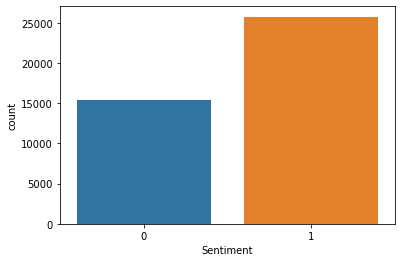

In [10]:
sns.countplot(x='Sentiment', data=train_df)

In [11]:
train_df.Sentiment.value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

In [12]:
train_df['length'] = train_df.OriginalTweet.apply(len)

<AxesSubplot:xlabel='Sentiment', ylabel='length'>

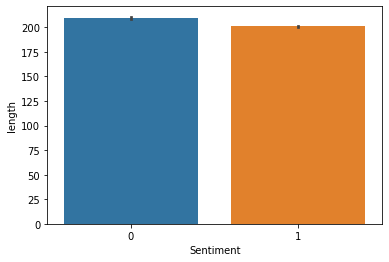

In [13]:
sns.barplot(x='Sentiment', y='length', data = train_df)

In [14]:
for x in train_df.loc[:10, 'OriginalTweet']:
    print(x)
    print('---------')

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
---------
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
---------
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
---------





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
---------




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n
---------
As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU
---

In [15]:
def remove_users_http(word):
    """Remove non-ASCII characters from list of tokenized words"""
    word = re.sub(r'http\S+', '', word)
    word = re.sub(r'@\w+', '', word)
    word = re.sub(r'#\w+', '', word)
    return word

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def form_sentence(tweet):
    tweet = remove_users_http(tweet)
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

In [16]:
train_df['Clean_text'] = train_df['OriginalTweet'].apply(form_sentence)
test_df['Clean_text'] = test_df['OriginalTweet'].apply(form_sentence)

In [17]:
train_df.head()

,OriginalTweet,Sentiment,length,Clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,111,"[and, and]"
1,advice Talk to your neighbours family to excha...,1,237,"[advice, Talk, to, your, neighbours, family, t..."
2,Coronavirus Australia: Woolworths to give elde...,1,131,"[Coronavirus, Australia, Woolworths, to, give,..."
3,My food stock is not the only one which is emp...,1,306,"[My, food, stock, is, not, the, only, one, whi..."
4,"Me, ready to go at supermarket during the #COV...",0,310,"[Me, ready, to, go, at, supermarket, during, t..."


In [18]:
test_df.head()

,OriginalTweet,Sentiment,Clean_text
0,TRENDING: New Yorkers encounter empty supermar...,0,"[TRENDING, New, Yorkers, encounter, empty, sup..."
1,When I couldn't find hand sanitizer at Fred Me...,1,"[When, I, could, n't, find, hand, sanitizer, a..."
2,Find out how you can protect yourself and love...,1,"[Find, out, how, you, can, protect, yourself, ..."
3,#Panic buying hits #NewYork City as anxious sh...,0,"[buying, hits, City, as, anxious, shoppers, st..."
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,"[One, week, everyone, buying, baby, milk, powd..."


In [19]:
train_df['Clean_text'] = train_df['Clean_text'].apply(normalize)
test_df['Clean_text'] = test_df['Clean_text'].apply(normalize)

In [20]:
train_df.head()

,OriginalTweet,Sentiment,length,Clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,111,[]
1,advice Talk to your neighbours family to excha...,1,237,"[advice, talk, neighbours, family, exchange, p..."
2,Coronavirus Australia: Woolworths to give elde...,1,131,"[coronavirus, australia, woolworths, give, eld..."
3,My food stock is not the only one which is emp...,1,306,"[food, stock, one, empty, please, nt, panic, e..."
4,"Me, ready to go at supermarket during the #COV...",0,310,"[ready, go, supermarket, outbreak, paranoid, f..."


In [21]:
test_df.head()

,OriginalTweet,Sentiment,Clean_text
0,TRENDING: New Yorkers encounter empty supermar...,0,"[trending, new, yorkers, encounter, empty, sup..."
1,When I couldn't find hand sanitizer at Fred Me...,1,"[could, nt, find, hand, sanitizer, fred, meyer..."
2,Find out how you can protect yourself and love...,1,"[find, protect, loved, ones]"
3,#Panic buying hits #NewYork City as anxious sh...,0,"[buying, hits, city, anxious, shoppers, stock,..."
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,"[one, week, everyone, buying, baby, milk, powd..."


In [22]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [23]:
train_df['Clean_text'] = train_df['Clean_text'].apply(fix_nt)
test_df['Clean_text'] = test_df['Clean_text'].apply(fix_nt)

In [24]:
train_df['Clean_text'] = train_df['Clean_text'].apply(lambda x: " ".join(x))
test_df['Clean_text'] = test_df['Clean_text'].apply(lambda x: " ".join(x))

In [25]:
train_df.head()

,OriginalTweet,Sentiment,length,Clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,111,
1,advice Talk to your neighbours family to excha...,1,237,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,1,306,food stock one empty pleasen't panic enough fo...
4,"Me, ready to go at supermarket during the #COV...",0,310,ready go supermarket outbreak paranoid food st...


In [26]:
test_df.head()

,OriginalTweet,Sentiment,Clean_text
0,TRENDING: New Yorkers encounter empty supermar...,0,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,1,couldn't find hand sanitizer fred meyer turned...
2,Find out how you can protect yourself and love...,1,find protect loved
3,#Panic buying hits #NewYork City as anxious sh...,0,buying hits city anxious shoppers stock food a...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,one week everyone buying baby milk powder next...


In [32]:
all_words = list(itertools.chain(*train_df.Clean_text))

In [33]:
dist = nltk.FreqDist(all_words)
dist

FreqDist({' ': 560127, 'e': 445559, 's': 291001, 'i': 269713, 'a': 268911, 'r': 262334, 'o': 259991, 'n': 241966, 't': 237246, 'l': 171969, ...})

In [34]:
len(dist)

29

In [35]:
max(train_df.Clean_text.apply(len))

263

In [36]:
from tensorflow import string as tf_string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [37]:
embedding_dim = 128 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 10000 # Number of unique tokens in vocabulary
sequence_length = 30 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(train_df.Clean_text.values)

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.Clean_text, train_df.Sentiment, test_size=0.1, random_state=13)

In [39]:
X_test = test_df.Clean_text
y_test = test_df.Sentiment

In [40]:
print('Vocabulary example: ', vect_layer.get_vocabulary()[:10])
print('Vocabulary shape: ', len(vect_layer.get_vocabulary()))

Vocabulary example:  ['', '[UNK]', 'covid', 'prices', 'food', 'store', 'supermarket', 'grocery', 'people', 'amp']
Vocabulary shape:  10000


In [41]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

In [42]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(64, activation='mish', return_sequences=True)(emb)
x = GRU(64, activation='mish', return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, 'mish')(x)
x = keras.layers.Dense(64, 'mish')(x)
x = keras.layers.Dense(32, 'mish')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            49408     
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            24960     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888

In [43]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=70, restore_best_weights=True)

batch_size = 128
epochs = 7
history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/7
290/290 [==============================] - 25s 75ms/step - loss: 0.5486 - accuracy: 0.7202 - val_loss: 0.3917 - val_accuracy: 0.8311
Epoch 2/7
290/290 [==============================] - 21s 73ms/step - loss: 0.3408 - accuracy: 0.8620 - val_loss: 0.3946 - val_accuracy: 0.8387
Epoch 3/7
290/290 [==============================] - 23s 80ms/step - loss: 0.2981 - accuracy: 0.8864 - val_loss: 0.3650 - val_accuracy: 0.8484
Epoch 4/7
290/290 [==============================] - 22s 76ms/step - loss: 0.2676 - accuracy: 0.8972 - val_loss: 0.3590 - val_accuracy: 0.8443
Epoch 5/7
290/290 [==============================] - 22s 76ms/step - loss: 0.2553 - accuracy: 0.9055 - val_loss: 0.3772 - val_accuracy: 0.8418
Epoch 6/7
290/290 [==============================] - 21s 72ms/step - loss: 0.2399 - accuracy: 0.9118 - val_loss: 0.3844 - val_accuracy: 0.8520
Epoch 7/7
290/290 [==============================] - 21s 74ms/step - loss: 0.2284 - accuracy: 0.9147 - val_loss: 0.3880 - val_accuracy: 0.8554

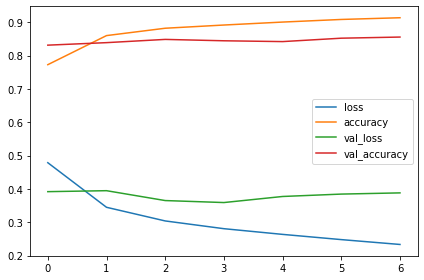

In [44]:
show_history(history)

In [45]:
y_test_loss, accuracy = model.evaluate(X_test, y_test)

119/119 [==============================] - 1s 8ms/step - loss: 0.4423 - accuracy: 0.8294


In [46]:
y_pred = model.predict(X_test).ravel()

In [55]:
X_test

0       trending new yorkers encounter empty supermark...
1       couldn't find hand sanitizer fred meyer turned...
2                                      find protect loved
3       buying hits city anxious shoppers stock food a...
4       one week everyone buying baby milk powder next...
                              ...                        
3793    meanwhile supermarket israel people dance sing...
3794    panic buy lot nonperishable items echo needs f...
3795    asst prof economics talking recent research co...
3796    gov need somethings instead biar je rakyat ass...
3797    members committed safety employees endusers mo...
Name: Clean_text, Length: 3798, dtype: object

In [47]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [48]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.8293838862559242

In [49]:
f1_score(y_true=y_test, y_pred=y_pred)

0.8569536423841059

# 模型应用

In [66]:
tweet_clean=pd.read_excel('/Users/kejinglin/Desktop/personal/mydata/tweet_clean_sentiment.xlsx')
tweet_clean.head()

,u_nickname,u_url,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publi,r_like_num,r_trans_num,verified,u_id,u_desc,u_fans,u_follow,u_login_time,u_area,topic_result
0,Pastor Mark Burns,https://twitter.com/pastormarkburns,Is it possible that President @realDonaldTrump...,NaN,1312427187220480000,NaN,NaN,43038,2020-10,41927,8776,1,39334221,"Husband, Father, South Carolina native,\nEntre...",148266,567,2009-05-12 04:31:45,South Carolina,3
1,Chuck Woolery,https://twitter.com/chuckwoolery,The most outrageous lies are the ones about Co...,NaN,1282499347117215745,NaN,NaN,41952,2020-07,66955,16983,1,462104542,"Hollywood Conservative, Love Connection Host, ...",563931,2367,2012-01-12 23:30:41,Texas,1
2,Dr. Saskia Popescu,https://twitter.com/SaskiaPopescu,"Stop. Calling. It. The. “China Virus"". \n\nJus...",NaN,1285684554230050817,NaN,NaN,34513,2020-07,10537,1470,1,26117944,ID Epi & infection prvntn | Asst Prof @ScharSc...,50247,886,2009-03-24 07:17:50,Phoenix & DC,5
3,ChuckGrassley,https://twitter.com/ChuckGrassley,I don’t understand why China gets upset bc we ...,NaN,1240245244169420800,NaN,NaN,34010,2020-03,24137,6355,1,10615232,U.S. Senator. Family farmer. Lifetime resident...,628280,12984,2007-11-26 23:17:02,Iowa,5
4,Barack Obama,https://twitter.com/BarackObama,We've seen all too terribly the consequences o...,NaN,1245007713387544576,NaN,NaN,34001,2020-03,331589,87307,1,813286,"Dad, husband, President, citizen.",129352049,594833,2007-03-06 06:08:25,"Washington, DC",4


In [67]:
tweet_clean['Clean_text'] = tweet_clean['m_content'].apply(form_sentence)

In [68]:
tweet_clean['Clean_text'] = tweet_clean['Clean_text'].apply(normalize)

In [69]:
tweet_clean['Clean_text'] = tweet_clean['Clean_text'].apply(fix_nt)

In [70]:
tweet_clean['Clean_text'] = tweet_clean['Clean_text'].apply(lambda x: " ".join(x))

In [71]:
tweet_clean['Clean_text']

0                             possible president amp team
1       outrageous lies ones covid everyone lying cdc ...
2                                stop calling china virus
3       understand china gets upset bc refer virus ori...
4       seen terribly consequences denied warnings pan...
                              ...                        
3353    pres trump travels heartland today encourage n...
3354    temple university genomic study genetic eviden...
3355    evidence people gain immunity covid catching d...
3356    guys really think racism way dishonest incompe...
3357    trump ordered day travel ban europe us uk exce...
Name: Clean_text, Length: 3358, dtype: object

In [72]:
sentiment=model.predict(tweet_clean['Clean_text']).ravel()

In [73]:
sentiment

array([0.94884133, 0.01066968, 0.04667187, ..., 0.90030134, 0.02578953,
       0.01700014], dtype=float32)

In [74]:
pd.DataFrame(sentiment).to_excel('/Users/kejinglin/Desktop/personal/mydata/sentiment_result_bert.xls',)

In [75]:
sentiment_result=pd.DataFrame(sentiment)
sentiment_result.describe()

,0
count,3.358000e+03
mean,5.164667e-01
std,4.167980e-01
min,1.676388e-11
25%,5.021494e-02
50%,5.631192e-01
75%,9.543029e-01
max,9.999977e-01
